In [2]:
# Import necessary libraries for preprocessing
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
from sklearn import tree
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge, ElasticNet

# Load the dataset
#Atlanta_Distance = pd.read_pickle(r'~/Documents/NYCDSA/Capstone/Pickle Files/Atlanta_Nearest_POI.pkl')
Atlanta_Distance = pd.read_csv('~/Documents/NYCDSA/Capstone/Nearest_Distances_Atlanta/Atlanta_Nearest_Distances.csv')
Atlanta_Distance['TotalBath'] = Atlanta_Distance['number_of_full_baths'] + (Atlanta_Distance['number_of_half_baths']*0.5)
Atlanta_Distance = Atlanta_Distance.drop(columns=['ID', 'year_built', 'source_name',
                                                  'listing_date', 'mls_id', 'census_zcta5_geoid',
                                                  'census_cbsa_geoid', 'latitude', 'longitude', 'lot_size_in_acres', 'number_of_full_baths', 'number_of_half_baths'])
Atlanta_Distance

,street_address,city,state,current_listing_price,number_of_bedrooms,living_area_square_feet,lot_size_in_square_feet,has_pool,has_garage,number_of_garage_spaces,...,Distance_SC,Convenience_POI,Distance_C,Supermarket_POI,Distance_SM,Variety_store_POI,Distance_VS,Wholesale_POI,Distance_WS,TotalBath
0,0 ivy MNR DR NW 0,Marietta,GA,2865,4,3259.0,14810.400390,False,True,NaN,...,2539.28,Sunoco,2715.74,Kroger,1654.08,Bargain Hunt,6405.99,Atlanta Wholesale,10917.45,2.5
1,1 10 buena VIS CIR SE,Cartersville,GA,2200,3,1993.0,NaN,False,False,NaN,...,492.63,Mack's Express,1407.26,Publix,3065.55,Dollar Tree,405.11,LI Global Liquidation,32739.68,2.0
2,1 1088 coldwater DR,Griffin,GA,2000,3,1910.0,NaN,False,True,NaN,...,25413.80,Unnamed POI,3213.19,Kroger,3780.13,Dollar General,4738.04,Costco,29267.11,2.0
3,1 1130 willivee DR,Decatur,GA,1995,3,1134.0,NaN,False,False,NaN,...,7857.71,Food Mart,2385.60,Publix,2320.59,Dollar Tree,4356.55,Sam's Club,9020.53,1.0
4,1 1307 idlewood CT,Mcdonough,GA,2800,4,2532.0,NaN,False,True,NaN,...,11676.91,Crossings at McDonough,14263.22,Kroger,5625.35,Dollar Tree,6721.22,Costco,14750.79,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21025,procurement only - 66 4th ST,Newnan,GA,1600,3,1367.0,NaN,False,True,NaN,...,19852.16,Newnan Lakes Chevron,4983.93,Little Giant Supermaket,2097.35,Family Dollar,6409.21,Two Valleys Distribution,47285.12,2.0
21026,r2188 executive DR,Duluth,GA,2199,3,1696.0,871.199981,False,False,NaN,...,4864.86,Unnamed POI,1477.04,Mega Mart,888.22,Dollar Tree,6142.54,Sam's Club,2009.36,2.5
21027,r3339 woodward down,Buford,GA,2380,3,1944.0,4356.000065,False,False,NaN,...,1359.41,Walgreens,3952.51,ALDI,1158.08,Five Below,714.63,Sam's Club,1507.23,3.5
21028,singleunit 216 greensprings DR,Palmetto,GA,1900,4,1204.0,NaN,False,False,NaN,...,10787.35,Flash Foods,1242.13,Publix,8779.81,Family Dollar,1402.52,Costco,40632.51,2.0


In [3]:
# Exclude 'current_listing_price' from features
numeric_features = Atlanta_Distance.select_dtypes(include=['int64', 'float64']).drop(columns=['current_listing_price']).columns
#categorical_features = list(Atlanta_Distance.columns[Atlanta_Distance.dtypes == 'object'])

In [4]:
# Helper function to fill 'None' for missing categorical data
def fill_none(X):
    return X.fillna("None")

# Pipeline for numeric features: Impute missing values using mean
numeric_transformer = Pipeline(steps=[
    ('impute_mean', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Pipeline for nominal categorical features: Fill missing values with 'None' then apply one-hot encoding
#categorical_transformer = Pipeline(steps=[
    #('impute_none', SimpleImputer(strategy='constant', fill_value='None')),  # Using SimpleImputer
    #('onehot', OneHotEncoder(handle_unknown='ignore'))
#])

# Combined preprocessor for numeric and nominal
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        #('nominal', categorical_transformer, categorical_features)
])

transformed_data = preprocessor.fit_transform(Atlanta_Distance)

In [5]:
# Generate column names for the one-hot encoded features
#onehot_features = preprocessor.named_transformers_['nominal'].named_steps['onehot'].get_feature_names_out()
# Combine all feature names
all_feature_names = list(numeric_features)
all_feature_names

['number_of_bedrooms',
 'living_area_square_feet',
 'lot_size_in_square_feet',
 'number_of_garage_spaces',
 'number_of_stories',
 'Distance_SC',
 'Distance_C',
 'Distance_SM',
 'Distance_VS',
 'Distance_WS',
 'TotalBath']

In [6]:
transformed_df = pd.DataFrame(transformed_data, columns=all_feature_names)
#transformed_df

In [14]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

# Target variable
y = Atlanta_Distance['current_listing_price']
# All features
X = Atlanta_Distance.drop(columns='current_listing_price')
models = LinearRegression()

coefficients_list = []
intercepts_list = []
scores = []
# Perform the KFold cross-validation
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', models),
])
# Initialize the linear regression model
# Fit the model on the training data
pipeline.fit(Atlanta_Distance.drop(columns='current_listing_price'), Atlanta_Distance['current_listing_price'])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute_mean',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['number_of_bedrooms', 'living_area_square_feet',
       'lot_size_in_square_feet', 'number_of_garage_spaces',
       'number_of_stories', 'Distance_SC', 'Distance_C', 'Distance_SM',
       'Distance_VS', 'Distance_WS', 'TotalBath'],
      dtype='object'))])),
                ('regressor', LinearRegression())])

In [15]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=10)
scores = cross_val_score(pipeline, Atlanta_Distance.drop(columns='current_listing_price'), Atlanta_Distance['current_listing_price'], scoring = 'r2', cv=kf, n_jobs = -1)

In [16]:
scores

array([ 0.18560202,  0.24106086,  0.13796858,  0.27779826,  0.28832131,
        0.29136132,  0.32350046,  0.30391784, -6.00188973,  0.25457043])

In [19]:
# Find the best score (maximum R^2 score)
best_score = scores.max()

print("Best R^2 score from cross-validation:", best_score)
print('Variance:',np.var(scores))

Best R^2 score from cross-validation: 0.3235004554602312
Variance: 3.527392717079801


In [141]:
coefficients = results.params
print(coefficients)

const                      2272.043272
number_of_bedrooms          244.122650
number_of_full_baths         64.732019
number_of_half_baths         77.931570
living_area_square_feet     226.018773
lot_size_in_square_feet      -0.503491
number_of_garage_spaces      17.340857
number_of_stories            12.935299
Distance_SC                -132.463947
Distance_C                  -82.659454
Distance_SM                 -45.235530
Distance_VS                  29.611938
Distance_WS                  42.608028
dtype: float64


In [136]:
fold_scores = []
fold_num = 1
for train_index, test_index in kf.split(Atlanta_Distance):
    X_train, X_test = Atlanta_Distance.drop(columns='current_listing_price').iloc[train_index],Atlanta_Distance.drop(columns='current_listing_price').iloc[test_index]
    y_train, y_test = Atlanta_Distance['current_listing_price'].iloc[train_index], Atlanta_Distance['current_listing_price'].iloc[test_index]
    pipeline.fit(X_train, y_train)
    fold_score = pipeline.score(X_test, y_test)
    print(f'Score for Fold: {fold_num}', fold_score)
    fold_scores.append({
        'score':fold_score,
        'fold':fold_num})
    fold_num += 1

Score for Fold: 1 0.19355556706211807
Score for Fold: 2 0.24730663214260218
Score for Fold: 3 0.14639334835931594
Score for Fold: 4 0.2843220017120114
Score for Fold: 5 0.28693747255457025
Score for Fold: 6 0.29721589758845635
Score for Fold: 7 0.32093948720542165
Score for Fold: 8 0.3091768653857262
Score for Fold: 9 -5.882459352487529
Score for Fold: 10 0.25704232525725723


In [137]:
from sklearn.metrics import mean_squared_error, r2_score, PredictionErrorDisplay
rmse_scores = []
r2_scores = []
coefs_per_fold = []

all_y_pred = []
all_y_actual = []
residuals = []

y = Atlanta_Distance['current_listing_price']


results_list = []

X = Atlanta_Distance.drop(columns='current_listing_price')

# cat_cols = [col for col in X.columns if X[col].dtype == 'object']

# if cat_cols:
#     encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
#     transformed_X = encoder.fit_transform(X[cat_cols])
#     transformed_X = pd.DataFrame(transformed_X.toarray(), columns=encoder.get_feature_names_out())
#     transformed_X.reset_index(drop=True, inplace=True)
#     X.reset_index(drop=True, inplace=True)
#     X = pd.concat([X.drop(columns=cat_cols), transformed_X], axis=1)

kf = KFold(n_splits = 10, shuffle = False)

for fold, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]        

    lm = pipeline
    lm.fit(X_train, y_train)

    coefs_per_fold.append(lm['regressor'].coef_)

    y_pred = lm.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    
    all_y_pred.extend(y_pred)
    all_y_actual.extend(y_test.values)
    residuals.extend(y_test.values - y_pred)
    
    print(f"Fold {fold+1}: RMSE = {round(rmse, 4)}, R2 = {round(r2, 4)}")

mean_rmse = np.mean(rmse_scores)
mean_r2 = np.mean(r2_scores)

print(f"Average RMSE: {round(mean_rmse, 4)}")
print(f"Std of RMSE: {round(np.std(rmse_scores), 4)}")
print(f"Average R2: {round(mean_r2, 4)}")
print(f"Std of R2: {round(np.std(r2_scores), 4)}")

Fold 1: RMSE = 903.9593, R2 = 0.1936
Fold 2: RMSE = 850.0188, R2 = 0.2473
Fold 3: RMSE = 844.1895, R2 = 0.1464
Fold 4: RMSE = 703.5177, R2 = 0.2843
Fold 5: RMSE = 685.8382, R2 = 0.2869
Fold 6: RMSE = 795.4949, R2 = 0.2972
Fold 7: RMSE = 715.4372, R2 = 0.3209
Fold 8: RMSE = 713.0243, R2 = 0.3092
Fold 9: RMSE = 2248.5185, R2 = -5.8825
Fold 10: RMSE = 858.8891, R2 = 0.257
Average RMSE: 931.8887
Std of RMSE: 444.9795
Average R2: -0.354
Std of R2: 1.8435


In [21]:
data = [['F1', 0.1933, 0.19], 
        ['F2', 0.2486, 0.25], 
        ['F3', 0.1487, 0.15], 
        ['F4', 0.2855, 0.29], 
        ['F5', 0.2862, 0.29],
        ['F6', 0.2984, 0.30], 
        ['F7', 0.3206, 0.32], 
        ['F8', 0.3097, 0.31], 
        ['F9', -5.881, -5.89], 
        ['F10', 0.2568, 0.26]]
df = pd.DataFrame(data, columns=['Fold', 'Score', 'mark_value'])

df

,Fold,Score,mark_value
0,F1,0.1933,0.19
1,F2,0.2486,0.25
2,F3,0.1487,0.15
3,F4,0.2855,0.29
4,F5,0.2862,0.29
5,F6,0.2984,0.30
6,F7,0.3206,0.32
7,F8,0.3097,0.31
8,F9,-5.8810,-5.89
9,F10,0.2568,0.26


C:\Users\immed\Programming\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\immed\Programming\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


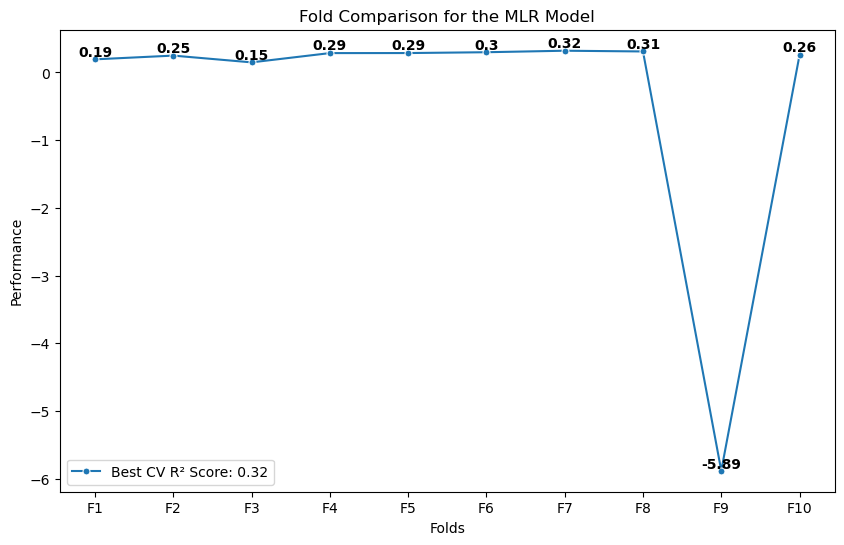

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['lines.markersize'] = 5

# Create the boxplot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x="Fold", y="Score", marker="o")
plt.xlabel('Folds')
plt.ylabel('Performance')
plt.title('Fold Comparison for the MLR Model')
plt.legend(markerscale=10)

palette = ['black', 'black', 'black', 'black', 'black','black', 'black', 'black', 'black', 'black']

for line in range(0,df.shape[0]):
     plt.text(df.Fold[line], df.mark_value[line], df.mark_value[line], horizontalalignment='center', verticalalignment ='bottom', size='medium', color='black', weight='semibold')

plt.legend(labels=['Best CV R² Score: 0.32'])
plt.show()

In [140]:
import statsmodels.api as sm
x = sm.add_constant(transformed_df)
y = list(Atlanta_Distance['current_listing_price'])
model= sm.OLS(y, x)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])
results = model.fit()
results.model.data.xnames = ['const'] + all_feature_names
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     607.3
Date:                Thu, 10 Oct 2024   Prob (F-statistic):               0.00
Time:                        16:57:15   Log-Likelihood:            -1.7003e+05
No. Observations:               21030   AIC:                         3.401e+05
Df Residuals:                   21017   BIC:                         3.402e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    2